## Data Description and Provenance

In [1]:
import pandas as pd
import numpy as np


# Load files
companies = pd.read_csv('data/sp500_companies.csv')
index_df  = pd.read_csv('data/sp500_index.csv')
stocks    = pd.read_csv('data/sp500_stocks.csv')


# Convert dates
index_df['Date'] = pd.to_datetime(index_df['Date'], errors='coerce')
stocks['Date']   = pd.to_datetime(stocks['Date'],   errors='coerce')


def missing_report(df, name):
   print(f"\n=== {name} ===")
   print(f"Shape: {df.shape}")
   if 'Date' in df.columns:
       print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
   missing = df.isnull().sum()
   percent = 100 * missing / len(df)
   report = pd.DataFrame({'Missing Count': missing, 'Percent Missing': percent})
   report = report[report['Missing Count'] > 0].sort_values('Percent Missing', ascending=False)
   if not report.empty:
       print("Missing values:")
       print(report.round(3))
   else:
       print("No missing values in any column.")
   print("-" * 50)


missing_report(companies, "data/sp500_companies.csv")
missing_report(index_df,  "data/sp500_index.csv")
missing_report(stocks,    "data/sp500_stocks.csv")


=== data/sp500_companies.csv ===
Shape: (502, 16)
Missing values:
                   Missing Count  Percent Missing
Ebitda                        29            5.777
State                         20            3.984
Fulltimeemployees              9            1.793
Revenuegrowth                  3            0.598
--------------------------------------------------

=== data/sp500_index.csv ===
Shape: (2517, 2)
Date range: 2014-12-22 00:00:00 to 2024-12-20 00:00:00
No missing values in any column.
--------------------------------------------------

=== data/sp500_stocks.csv ===
Shape: (1891536, 8)
Date range: 2010-01-04 00:00:00 to 2024-12-20 00:00:00
Missing values:
           Missing Count  Percent Missing
Adj Close         100475            5.312
Close             100475            5.312
High              100475            5.312
Low               100475            5.312
Open              100475            5.312
Volume            100475            5.312
------------------------------

### Data Description and Missing Value Summary

This project uses three related datasets describing the S&P 500 index and its constituent companies.

(a) sp500_companies.csv

- Shape: (502 × 16)  
- Description: Contains company-level metadata and financial indicators for S&P 500 constituents.  
- Key columns: Exchange, Symbol, Shortname, Sector, Industry, Currentprice, Marketcap, Ebitda, Revenuegrowth, Fulltimeemployees, etc.  

Missing Data:

| Column             | Missing Count | Percent Missing |
|--------------------|---------------|-----------------|
| Ebitda             | 29            | 5.78%           |
| State              | 20            | 3.98%           |
| Fulltimeemployees  | 9             | 1.79%           |
| Revenuegrowth      | 3             | 0.60%           |

Interpretation: 
Most missing data appear in financial fields (Ebitda, Revenuegrowth) and location-related fields (State).  
These gaps likely stem from incomplete corporate disclosures or companies headquartered outside the U.S.  
The dataset otherwise has complete coverage of essential identification and classification fields such as Symbol and Sector.

(b) sp500_index.csv

- Shape: (2,517 × 2)  
- Date range: 2014-12-22 → 2024-12-20  
- Columns: Date, S&P500 (daily closing level).  
- Missing data: None detected.  

Interpretation:  
The index file is fully complete, covering approximately ten years of daily observations.  
This makes it an ideal foundation for modeling index-level returns or volatility.

(c) sp500_stocks.csv

- Shape: (1,891,536 × 8)  
- Date range: 2010-01-04 → 2024-12-20  
- Columns: Date, Symbol, Open, High, Low, Close, Adj Close, Volume.  

Missing Data:

| Column     | Missing Count | Percent Missing |
|-------------|----------------|-----------------|
| Adj Close   | 100,475        | 5.31%           |
| Close       | 100,475        | 5.31%           |
| High        | 100,475        | 5.31%           |
| Low         | 100,475        | 5.31%           |
| Open        | 100,475        | 5.31%           |
| Volume      | 100,475        | 5.31%           |

Interpretation:  
We will investigate the missing values further in the next code block.

### Data Provenance

The datasets used in this project originate from the Kaggle dataset  
**[“S&P 500 Stocks”](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)**.  
This dataset aggregates information about S&P 500 companies, their historical prices, and the overall index level.

Source Details:
- Platform: Kaggle  
- Dataset Owner: Larxel (dataset maintainer)  
- Collection Methodology: Data collected from the Federal Reserve Economic Data (FRED) and the Yahoo Finance (yfinance) API.  
- License: CC0: Public Domain 
- Update Frequency: Daily (last updated approximately one year ago)  
- Temporal Coverage: 2010–2024   
- Dataset Version Used: v1022 (the most recent reliable version)  

> Note:
> The latest version of the dataset (v1023) contains approximately 67% missing values, rendering it unsuitable for analysis.  
> Therefore, this project uses version 1022, which provides complete and consistent coverage for the S&P 500 index and its constituent stock data. 

In [2]:
price_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
full_missing = stocks[price_cols].isna().all(axis=1)


# 1. Count missing rows per ticker
missing_per_ticker = (
   full_missing.groupby(stocks['Symbol'])
   .sum()
   .astype(int)
   .sort_values(ascending=False)
)


# 2. Show results
print(f"Total missing rows: {full_missing.sum():,}")
print(f"Tickers with missing data: {missing_per_ticker[missing_per_ticker > 0].shape[0]}")


print("\n--- Top 15 tickers with MOST missing days ---")
print(missing_per_ticker.head(15).to_string())

Total missing rows: 100,475
Tickers with missing data: 72

--- Top 15 tickers with MOST missing days ---
Symbol
AMTM    3705
SW      3650
SOLV    3583
GEV     3583
VLTO    3461
KVUE    3356
GEHC    3261
CEG     3032
ABNB    2754
PLTR    2704
CARR    2569
OTIS    2569
CRWD    2375
CTVA    2363
UBER    2353


### Missing values in `sp500_stocks.csv'

We examined which specific tickers had missing data in the sp500_stocks.csv dataset.  
Out of approximately 1.89 million rows (covering 2010–2024), there are 100,475 rows with missing values across *all* price and volume columns — about 5.31% of the dataset.  

Only 72 tickers are affected, primarily recent S&P 500 additions such as AMTM (3,705 missing days), SW, GEV, and SOLV (2024 spin-offs), followed by VLTO, KVUE, GEHC, CEG, ABNB, PLTR, OTIS, CARR, CRWD, CTVA, and UBER (added between 2019–2023).  

These gaps correspond to periods before each company joined the index, not data errors.  
They occur because the dataset spans the entire 2010–2024 period, even though many of these firms entered the S&P 500 mid-period.  
The remaining ~430 tickers have complete trading histories.  

This pattern of missingness is structural and expected, reflecting real-world index composition changes rather than issues with data collection.


## Phenomenon and Background

The **S&P 500** tracks 500 major U.S. companies and is widely used as a benchmark for market performance. Its daily movements reflect complex interactions among economic forces, investor behavior, and external events. Modeling these dynamics helps us understand short-term market behavior and assess whether simple statistical models can reproduce real trends.

### Research Focus
This project asks:

> *Can non-parametric models—specifically Markov chains—capture short-term S&P 500 price dynamics, and do their simulations resemble actual market patterns?*

### Background
Under the **Efficient Market Hypothesis (EMH)**, future price changes should be unpredictable. In practice, however, stock returns show short-term persistence and volatility clustering.  
**Non-parametric models** offer a flexible way to study these patterns without assuming linear or parametric relationships.

- **Markov Chains:** model discrete market states (Bull, Bear, Stable) and the probabilities of moving between them day to day.

### Dataset Connection
We use daily adjusted close prices for all S&P 500 constituents (2013–2024). Some data are structurally missing for companies added or removed from the index; these are excluded to avoid bias. Grouping by **sector** allows comparison of transition behavior across industries.

### Objective
By combining kernel smoothing and Markov modeling, we test whether short-term market behavior can be described by simple, data-driven transitions and how closely simulated state distributions match observed ones.

In [ ]:
index = index.rename(columns={"S&P500": "Price"})
index.head(5)

,Date,Price
0,2014-12-22,2078.54
1,2014-12-23,2082.17
2,2014-12-24,2081.88
3,2014-12-26,2088.77
4,2014-12-29,2090.57


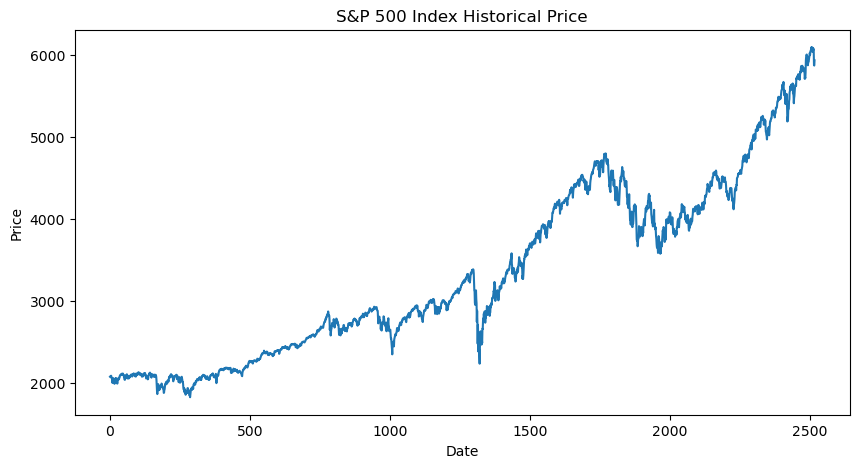

In [ ]:
index["Price"].plot(figsize=(10, 5))
plt.title("S&P 500 Index Historical Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

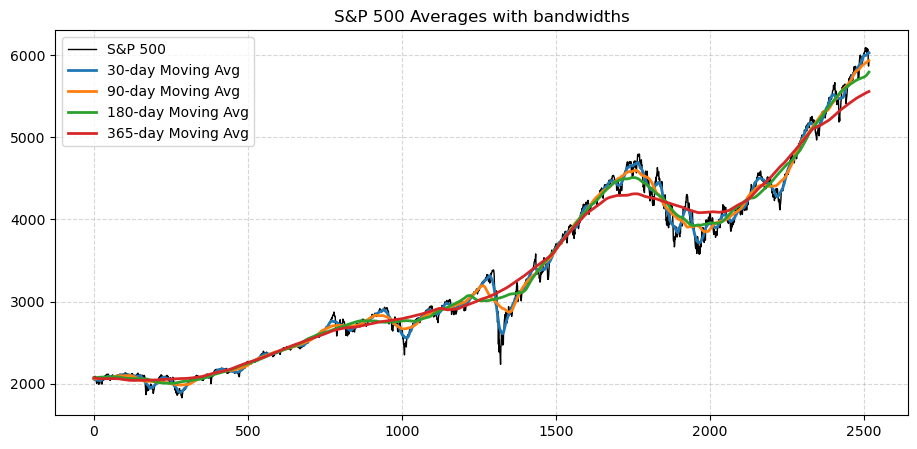

In [ ]:
import matplotlib.pyplot as plt

# testing different bandwidths
windows = [30, 90, 180, 365]
fig, ax = plt.subplots(figsize=(11, 5))
index["Price"].plot(ax=ax, label="S&P 500", color="black", linewidth=1)

for w in windows:
    avg = index["Price"].rolling(window=w, center=True, min_periods=w//2).mean()
    avg.plot(ax=ax, linewidth=2, label=f"{w}-day Moving Avg")

plt.title("S&P 500 Averages with bandwidths")
plt.grid(linestyle="--", alpha=0.5)
plt.legend()
plt.show()


The graph above helps us to visualize the trends of the S&P 500 and to visually see the differences between rolling averages. If we are looking at the 90 v 180 trends if the 90 day trend negatively passes the 180 day trend it is advised to sell verses if the opposite occurs it is advised to buy. This console is based off the general trend of the stock market verses the trends of the market on a more frequent analysis.